# Tutorial 9 - 2D LCT apertured cavity scan using a krylov solver

This notebook essentially reproduces the plot from figure 4 in the "Modeling circulating cavity fields using the discrete linear canonical transform"

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
plt.style.use('user.mplstyle')

import LCT_functions as lctf
import optical_functions as of

## Model parameters

In [7]:
T_ITM = 0.014
T_ETM = 5e-6
R_ITM = 1 - T_ITM
R_ETM = 1 - T_ETM

t_ITM = np.sqrt(T_ITM)
t_ETM = np.sqrt(T_ETM)
r_ITM = np.sqrt(R_ITM)
r_ETM = np.sqrt(R_ETM)

RoC_ITM = 1934
RoC_ETM = 2245
len_ARM = 3994.5
TM_aperture_diam = 32.6e-2
TM_aperture_radius = TM_aperture_diam/2

md = of.abcd_space(len_ARM)
m1 = of.abcd_mirror(RoC_ITM)
m2 = of.abcd_mirror(RoC_ETM)

r_rt = r_ITM*r_ETM
m_rt = m1@md@m2@md
q_eig = of.q_eig(m_rt)
g_rt = of.accum_gouy_Siegman_nm(q_eig, m_rt, n=0, m=0)

In [63]:
N, M = 201, 202
q_inc = q_eig # input beam is perfectly mode matched
q_to_ETM = of.q_propag(q_inc, md)
w_ITM = of.q2w(q_inc)
w_ETM = of.q2w(q_to_ETM)

xs_ITM = np.linspace(-1, 1, N) * 4*w_ITM
ys_ITM = np.linspace(-1, 1, M) * 4*w_ITM
dx_ITM = xs_ITM[1] - xs_ITM[0]
dy_ITM = ys_ITM[1] - ys_ITM[0]

xs_ETM = np.linspace(-1, 1, N) * 4*w_ETM
ys_ETM = np.linspace(-1, 1, M) * 4*w_ETM
dx_ETM = xs_ETM[1] - xs_ETM[0]
dy_ETM = ys_ETM[1] - ys_ETM[0]

P_in = 1

u00 = of.u_nm_q(xs_ITM, ys_ITM, q_inc, q_inc, 0, 0)
u06 = of.u_nm_q(xs_ITM, ys_ITM, q_inc, q_inc, 0, 6)
u01 = of.u_nm_q(xs_ITM, ys_ITM, q_inc, q_inc, 0, 1)
# input beam is equal parts hg00, hg01, and hg06 as in the paper
U_inc = u00 + u01 + u06
U_inc /= np.sqrt(np.sum(abs(U_inc)**2)*dx_ITM*dy_ITM) / np.sqrt(P_in)

In [64]:
# define aperture maps

ap_map_ITM = np.ones([M, N], dtype=float)
ap_map_ITM[np.add.outer(ys_ITM**2, xs_ITM**2) > TM_aperture_radius**2] = 0

ap_map_ETM = np.ones([M, N], dtype=float)
ap_map_ETM[np.add.outer(ys_ETM**2, xs_ETM**2) > TM_aperture_radius**2] = 0

In [65]:
# define curvature maps

C_x_ETM = lctf.CM_kernel(xs_ETM, -2/RoC_ETM, diag=True)
C_y_ETM = lctf.CM_kernel(ys_ETM, -2/RoC_ETM, diag=True)
Rc_map_ETM = np.outer(C_y_ETM, C_x_ETM)

C_x_ITM = lctf.CM_kernel(xs_ITM, -2/RoC_ITM, diag=True)
C_y_ITM = lctf.CM_kernel(ys_ITM, -2/RoC_ITM, diag=True)
Rc_map_ITM = np.outer(C_y_ITM, C_x_ITM)

In [66]:
# define propagation operators

D_x_ITM_to_ETM = lctf.DLCT(xs_ITM, xs_ETM, M_abcd=md)
D_y_ITM_to_ETM = lctf.DLCT(ys_ITM, ys_ETM, M_abcd=md)

D_x_ETM_to_ITM = lctf.DLCT(xs_ETM, xs_ITM, M_abcd=md)
D_y_ETM_to_ITM = lctf.DLCT(ys_ETM, ys_ITM, M_abcd=md)

In [67]:
Nphi = 301
phis_plot = np.linspace(-20, 380, Nphi)
out = np.zeros([Nphi, M, N], dtype=np.complex128)


U_inc_at_ITM = U_inc * 1j*t_ITM * ap_map_ITM

# krylov solvers only take in 1D arrays
U_in = np.ravel(U_inc_at_ITM)

for k, phi in enumerate(phis_plot):
    print(f'{(k+1)/Nphi*100 :0.2f}%', end=' '*90+'\r')
    g = np.exp(-1j*phi/180*np.pi)
    
    # normalize the eigenvalue to use it for putting the cavity on resonance
    cavity_phase_tuning = np.conj(g_rt)

    def op_rt(v):
        '''Round trip operator. Put in mirror reflectivities and put the cavity on resonance.
        '''
        Xin = np.reshape(v, [M,N])
        X1 = D_y_ITM_to_ETM@Xin@D_x_ITM_to_ETM.T
        X2 = ap_map_ETM*Rc_map_ETM*X1*r_ETM
        X3 = D_y_ETM_to_ITM@X2@D_x_ETM_to_ITM.T
        X4 = ap_map_ITM*Rc_map_ITM*X3*r_ITM*cavity_phase_tuning*g
        return np.ravel(X4)

    def op_circ(v):
        '''Circulating operator is identity operator minus round trip operator.
        '''
        return v - op_rt(v)

    linop_circ = scipy.sparse.linalg.LinearOperator(matvec=op_circ, shape=[N*M,N*M])
    U_circ, _ = scipy.sparse.linalg.gmres(linop_circ, np.ravel(U_in))
    
    out[k,:,:] = np.reshape(U_circ, [M,N])

In [68]:
cavity_scan = np.sum(np.sum(np.abs(out)**2, axis=1), axis=1)*dy_ITM*dx_ITM

Text(0, 0.5, 'Circulating power [W]')

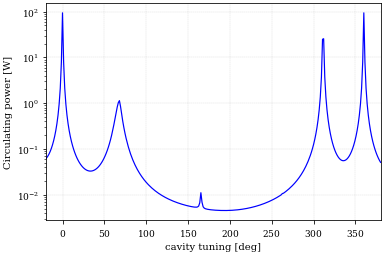

In [69]:
plt.semilogy(phis_plot, cavity_scan)
plt.xlabel('cavity tuning [deg]')
plt.ylabel('Circulating power [W]')